# References
Framework from https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

In [1]:
# load modules
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os
import gc
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt

# load labels & filenames
path = "../input/" 
train_path = path + 'train/'
test_path = path + 'test/'
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # filenames
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0]) 
labels = pd.read_csv(path+"train_labels.csv")
df = df.merge(labels, on = "id") 

# load data function
def load_data(N,df):
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.squeeze(df.as_matrix(columns=['label']))[0:N]
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
    return X,y


Using TensorFlow backend.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


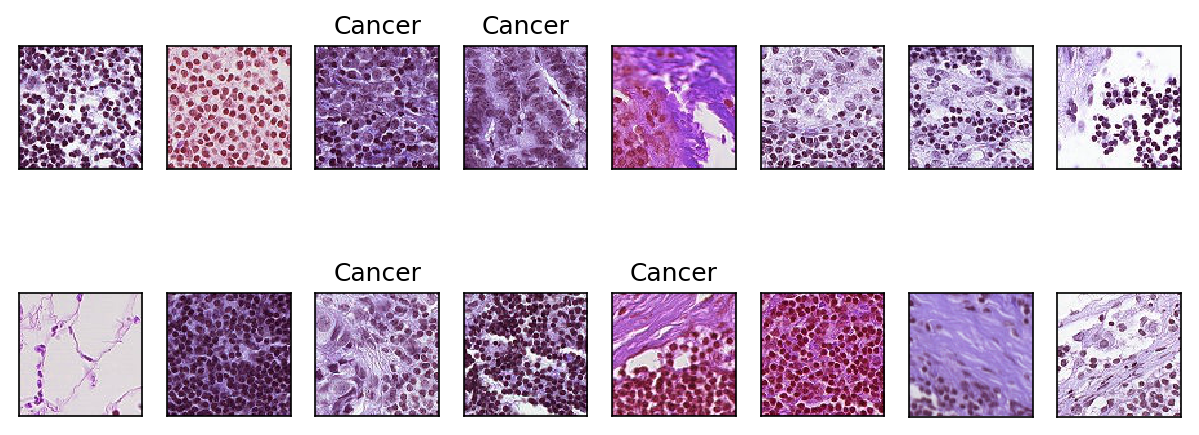

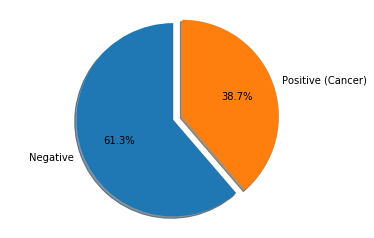

In [2]:
# EDA using N = 1,000
N=1000
X,y = load_data(N=N,df=df) 

# 16 random, labeled images
fig = plt.figure(figsize=(10, 4), dpi=150)
np.random.seed(10) #random seed
for plotNr,idx in enumerate(np.random.randint(0,N,16)):
    ax = fig.add_subplot(2, 16//2, plotNr+1, xticks=[], yticks=[]) #subplots
    plt.imshow(X[idx]) #plot
    if y[idx] == 0:
        a = " "
    else:
        a = "Cancer"
    ax.set_title(a)
    
# pie chart data distribution
labels = 'Negative', 'Positive (Cancer)'
sizes = [(y==0).sum(), (y==1).sum()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [3]:
# training
N = df["path"].size
#N = 100000 
x_train, y_train = load_data(N=N,df=df)

# 20,000 samples for validation
x_val = x_train[-20000:]
y_val = y_train[-20000:]
x_train = x_train[:-20000]
y_train = y_train[:-20000]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [4]:
kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()

# 1st layer 
model.add(Conv2D(first_filter, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# 2nd layer 
model.add(Conv2D(second_filter, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# 3rd layer 
model.add(Conv2D(third_filter, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# end layer
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

In [5]:
# compiling the model
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

# training the model
model.fit(
    x_train,
    y_train,
    batch_size=50,
    epochs=4,
    validation_data=(x_val, y_val),
)

Train on 200025 samples, validate on 20000 samples
Epoch 1/4
200025/200025 [==============================] - 94s 469us/step - loss: 0.3751 - acc: 0.8387 - val_loss: 0.5042 - val_acc: 0.7657
Epoch 2/4
200025/200025 [==============================] - 89s 446us/step - loss: 0.3012 - acc: 0.8756 - val_loss: 0.2798 - val_acc: 0.8852
Epoch 3/4
200025/200025 [==============================] - 89s 444us/step - loss: 0.2626 - acc: 0.8942 - val_loss: 0.3752 - val_acc: 0.8381
Epoch 4/4
200025/200025 [==============================] - 89s 447us/step - loss: 0.2349 - acc: 0.9074 - val_loss: 0.2542 - val_acc: 0.8975


In [6]:
X = None
y = None
gc.collect();

base_test_dir = path + 'test/' 
test_files = glob(os.path.join(base_test_dir,'*.tif')) 
submission = pd.DataFrame() 
file_batch = 5000 
max_idx = len(test_files) 
for idx in range(0, max_idx, file_batch): 
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) 
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0]) 
    test_df['image'] = test_df['path'].map(cv2.imread) 
    K_test = np.stack(test_df["image"].values) 
    predictions = model.predict(K_test,verbose = 1) 
    test_df['label'] = predictions 
    submission = pd.concat([submission, test_df[["id", "label"]]])
#submission.head()

Indexes: 0 - 5000
5000/5000 [==============================] - 1s 187us/step
Indexes: 5000 - 10000
5000/5000 [==============================] - 1s 160us/step
Indexes: 10000 - 15000
5000/5000 [==============================] - 1s 157us/step
Indexes: 15000 - 20000
5000/5000 [==============================] - 1s 164us/step
Indexes: 20000 - 25000
5000/5000 [==============================] - 1s 161us/step
Indexes: 25000 - 30000
5000/5000 [==============================] - 1s 159us/step
Indexes: 30000 - 35000
5000/5000 [==============================] - 1s 160us/step
Indexes: 35000 - 40000
5000/5000 [==============================] - 1s 162us/step
Indexes: 40000 - 45000
5000/5000 [==============================] - 1s 158us/step
Indexes: 45000 - 50000
5000/5000 [==============================] - 1s 157us/step
Indexes: 50000 - 55000
5000/5000 [==============================] - 1s 151us/step
Indexes: 55000 - 60000
2458/2458 [==============================] - 0s 164us/step


In [7]:
submission.to_csv("submission.csv", index = False, header = True) #submission 